# Evaluating model performance

## Load Data

We create the same train/test split as before and attempt to understand where the model is getting confused. As discussed in the previous section we want to identify when the model is making large mistakes, eg when a negative case is predicted as positive to understand how the model is making predictions.

We load in the saved fine-tuned model that we made in the previous section and investigate where it makes mistakes.

In [1]:
import random
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import torch.nn.functional as F

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/finBERT_5class_model_v4"


Mounted at /content/drive


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # set model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

id2label = model.config.id2label
label2id = model.config.label2id

print("Using device:", device)
print("id2label mapping:", id2label)


Using device: cuda
id2label mapping: {0: 'moderate_negative', 1: 'moderate_positive', 2: 'negative', 3: 'neutral', 4: 'positive'}


In [4]:
ds = load_dataset("FinGPT/fingpt-sentiment-train", split="train")

mapping_5 = {
    "strong negative": "negative",
    "moderately negative": "moderate_negative",
    "mildly negative": "moderate_negative",
    "negative": "negative",
    "neutral": "neutral",
    "mildly positive": "moderate_positive",
    "moderately positive": "moderate_positive",
    "positive": "positive",
    "strong positive": "positive"
}

def map_to_5(example):
    example["label_5"] = mapping_5[example["output"]]
    return example

ds = ds.map(map_to_5)

def encode_label(example):
    example["label"] = label2id[example["label_5"]]
    return example

ds = ds.map(encode_label)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/529 [00:00<?, ?B/s]

data/train-00000-of-00001-dabab110260ac9(…):   0%|          | 0.00/6.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76772 [00:00<?, ? examples/s]

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

Map:   0%|          | 0/76772 [00:00<?, ? examples/s]

In [5]:
ds = ds.train_test_split(test_size=0.2, seed=42)
test_ds = ds["test"]


In [6]:
def tokenize(batch):
    return tokenizer(batch["input"], truncation=True, padding="max_length", max_length=128)

test_ds = test_ds.map(tokenize, batched=True)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "input"])


Map:   0%|          | 0/15355 [00:00<?, ? examples/s]

## Validation Set Predictions

Here we recover our predictions and create a data frame of the mistakes made. The data frame tells us the input sentence we use to predict as well as its true and predicted labels. We also extract the softmax probabilities for each entry so we can examine how confident the model is in each prediction.

In [7]:
batch_size = 64

all_preds = []
all_labels = []
all_probs = []
all_texts = []

for i in range(0, len(test_ds), batch_size):
    batch = test_ds[i:i+batch_size]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1)  # softmax probabilities

    preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_probs.extend(probs.cpu().numpy())
    all_texts.extend(batch["input"])


In [8]:
# Convert to label names
pred_labels_names = [id2label[i] for i in all_preds]
true_labels_names = [id2label[i] for i in all_labels]

# Probability columns
prob_columns = [f"prob_{id2label[i]}" for i in range(len(id2label))]
df_results = pd.DataFrame({
    "sentence": all_texts,
    "true_label": true_labels_names,
    "pred_label": pred_labels_names,
    "correct": [t == p for t, p in zip(true_labels_names, pred_labels_names)]
})

# Add probability columns
for i, col in enumerate(prob_columns):
    df_results[col] = [p[i] for p in all_probs]

# Mistakes
mistakes = df_results[df_results["correct"] == False]

print("Total test samples:", len(df_results))
print("Number of mistakes:", len(mistakes))
print("\nSample misclassifications:")
mistakes.head(10)


Total test samples: 15355
Number of mistakes: 1380

Sample misclassifications:


,sentence,true_label,pred_label,correct,prob_moderate_negative,prob_moderate_positive,prob_negative,prob_neutral,prob_positive
44,"Candle Media founder and co-CEO Kevin Mayer, a...",neutral,moderate_positive,False,0.026490,0.777036,0.005544,0.189083,0.001848
68,"Byron Deeter, Bessemer Venture Partners, joins...",neutral,moderate_positive,False,0.284708,0.426072,0.012902,0.274939,0.001380
78,$XAUUSD:CUR $GLD $IAU - Gold gets jiggy after ...,positive,negative,False,0.000630,0.000738,0.699561,0.063452,0.235619
100,Highlight: @ArgusResearch Senior Analyst Bill ...,positive,neutral,False,0.000624,0.000492,0.073080,0.877456,0.048348
104,The operator is one of 6 operators to have bee...,neutral,positive,False,0.001191,0.064763,0.000940,0.429467,0.503639
112,Increase Your Credit Score With This 1 Trick,neutral,moderate_positive,False,0.016853,0.600249,0.008681,0.277336,0.096881
134,Netflix's latest earnings report may have give...,moderate_positive,moderate_negative,False,0.685556,0.285634,0.013473,0.014395,0.000942
150,"Compared with the FTSE 100 index , which rose ...",neutral,negative,False,0.008685,0.001527,0.950097,0.035251,0.004440
179,We have well and truly arrived at the December...,neutral,moderate_positive,False,0.007058,0.935145,0.002467,0.052070,0.003259
190,A look into Cathie Woods's portfolio shows som...,neutral,moderate_positive,False,0.009880,0.944928,0.003613,0.038513,0.003065


We have also recreated the classification report for reference.

In [9]:
from sklearn.metrics import classification_report

print("Classification Report on Test Set:\n")
print(classification_report(
    y_true=true_labels_names,
    y_pred=pred_labels_names,
    target_names=list(id2label.values())
))


Classification Report on Test Set:

                   precision    recall  f1-score   support

moderate_negative       0.72      0.86      0.79       962
moderate_positive       0.75      0.87      0.81      1729
         negative       0.93      0.95      0.94      2432
          neutral       0.97      0.88      0.92      5880
         positive       0.95      0.96      0.96      4352

         accuracy                           0.91     15355
        macro avg       0.86      0.90      0.88     15355
     weighted avg       0.92      0.91      0.91     15355



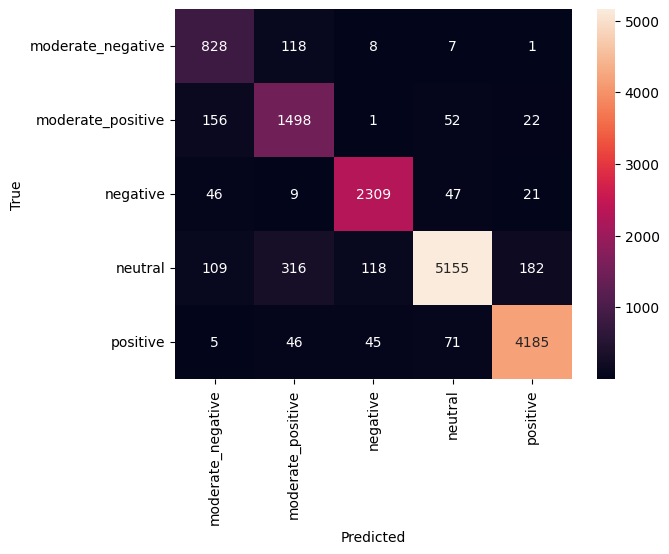

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_names, pred_labels_names)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

One thing the confusion matrix shows is that the model is generally good at identifying the 'magnitude' of the sentiment, ie confusing moderate and neutral classes. However, it often confuses the direction of the sentiment, misclassifying moderate postitive and moderate negative. Worryingly we also have 66 instances where negative and positive classes are misclassified with each other.

This indicates that the model has correctly identified strong sentiment but is not always successful at identifying whether that sentiment is positive or negative.

## 'Extreme' Errors

We consider the ordinality of our labels and use that to identify the extreme mistakes: postive predicted negative and vice versa.

In [11]:
ordinal_map = {
    "negative": 0,
    "moderate_negative": 1,
    "neutral": 2,
    "moderate_positive": 3,
    "positive": 4
}

df_results["true_ord"] = df_results["true_label"].map(ordinal_map)
df_results["pred_ord"] = df_results["pred_label"].map(ordinal_map)

# Ordinal distance
df_results["error_distance"] = (df_results["true_ord"] - df_results["pred_ord"]).abs()

In [12]:
# Check if probability columns are in df_results. If not, re-add them.
# This ensures df_results has all necessary columns before filtering.
if not all(col in df_results.columns for col in prob_columns):
    # This loop is typically in an earlier cell, but re-run here if state is lost.
    for i, col in enumerate(prob_columns):
        df_results[col] = [p[i] for p in all_probs]

# Now, extreme_errors can be safely created with the probability columns
extreme_errors = df_results[df_results["error_distance"] == 4]

cols_to_show = [
    "sentence",
    "true_label",
    "pred_label",
    "error_distance"
] + prob_columns

extreme_errors.head(15)[cols_to_show]

,sentence,true_label,pred_label,error_distance,prob_moderate_negative,prob_moderate_positive,prob_negative,prob_neutral,prob_positive
78,$XAUUSD:CUR $GLD $IAU - Gold gets jiggy after ...,positive,negative,4,0.000630,0.000738,0.699561,0.063452,0.235619
462,Consumer Credit Growth Rebounds In October #ec...,positive,negative,4,0.001711,0.001025,0.773156,0.045088,0.179021
550,$ECONX: November Nonfarm Private Payrolls 125K...,negative,positive,4,0.000671,0.001156,0.187603,0.302763,0.507807
753,Ameritrade shares ascend toward multimonth hig...,positive,negative,4,0.000367,0.000243,0.933407,0.050871,0.015111
828,BREAKING: Mortgage forbearance requests jump n...,negative,positive,4,0.000739,0.000922,0.050083,0.146646,0.801611
1692,SurveyMonkey CEO: Our data shows Uber could ra...,positive,negative,4,0.005009,0.001856,0.467756,0.132279,0.393100
1997,"At the end of the review period , Nordic Alumi...",positive,negative,4,0.000962,0.001001,0.816129,0.003419,0.178489
2078,"Net interest income totaled EUR 15.9 mn , comp...",positive,negative,4,0.001208,0.001483,0.673633,0.003529,0.320146
2372,$ECONX: November Unemployment Rate 3.5% vs 3.6...,positive,negative,4,0.000914,0.000763,0.794628,0.111218,0.092477
2564,U.S. stocks are 📈 https://t.co/2cVbN4AIF4 http...,positive,negative,4,0.001128,0.000929,0.820350,0.078241,0.099352


In [13]:
for i, row in extreme_errors.head(10).iterrows():
    print(f"\nSentence: {row['sentence']}")
    print(f"True: {row['true_label']}    Predicted: {row['pred_label']}")
    print("-" * 60)


Sentence: $XAUUSD:CUR $GLD $IAU - Gold gets jiggy after Fed actions https://t.co/gRrR8mCP0d
True: positive    Predicted: negative
------------------------------------------------------------

Sentence: Consumer Credit Growth Rebounds In October #economy #MarketScreener https://t.co/Q24jOfYhMs https://t.co/QUq0lgYCaq
True: positive    Predicted: negative
------------------------------------------------------------

Sentence: $ECONX: November Nonfarm Private Payrolls 125K vs 153K https://t.co/M9gpUZQoF7 consensus https://t.co/fav5NvyRH3
True: negative    Predicted: positive
------------------------------------------------------------

Sentence: Ameritrade shares ascend toward multimonth high and Schwab dips on deal news https://t.co/PnkM9Zz8fb
True: positive    Predicted: negative
------------------------------------------------------------

Sentence: BREAKING: Mortgage forbearance requests jump nearly 2,000% as borrowers seek relief during coronavirus outbreak https://t.co/5vbo5C2VC9
T

## Helper for single-sentence prediction

This helper function allows us to quickly predict the sentiment of a sentence using our model. Therefore we can quickly test our theories for how the model is predicting, and what it struggles with.

In [14]:
import torch
import torch.nn.functional as F

def predict_sentence(model, tokenizer, sentence, device):
    # Tokenize
    encoded = tokenizer(
        sentence,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    pred_class_id = probs.argmax()

    # Map ID → label name
    pred_label = id2label[pred_class_id]

    return {
        "sentence": sentence,
        "pred_label": pred_label,
        "probabilities": {id2label[i]: float(probs[i]) for i in range(len(probs))}
    }



## 1. The Model Struggles with Numerical Reasoning

The model is trained for natural language processing, not numerical reasoning. Therefore when the sentiment is implicit on numerical understanding the model struggles. For example

 * "Net interest income totaled EUR 15.9 mn , compared to EUR 15.6 mn a year earlier"
 * "At the end of the review period , Nordic Aluminium 's order book stood at EUR 8.77 mn compared to EUR 7.04 in 2005"
 * "$ECONX: November Unemployment Rate 3.5% vs 3.6% https://t.co/M9gpUZQoF7 consensus https://t.co/p5wq6wH9wr"



 There are a number of things the model must 'learn' to correctly classify this sentence. Firstly identifying which number is bigger, secondly whether having a bigger number of this thing is positive, and finally have we increased or decreased. This is subtle as despite 15.9 coming first in the sentence we have actually increased from 15.6 mn to 15.9 mn.

 In this sentence there are no positivity cues in the wording such as 'soars', 'beats expectations' or soars.

In [17]:
original = "Net interest income totaled EUR 15.9 mn , compared to EUR 15.6 mn a year earlier ."
modified = "Net interest income increased from EUR 15.6 mn to EUR 15.9 mn ."

from pprint import pprint

result_original = predict_sentence(model, tokenizer, original, device)
result_modified = predict_sentence(model, tokenizer, modified, device)

print("Original Sentence Prediction:")
pprint(result_original, width=80)

print("\nModified Sentence Prediction:")
pprint(result_modified, width=80)


Original Sentence Prediction:
{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.0012078725267201662,
                   'moderate_positive': 0.0014831704320386052,
                   'negative': 0.6736304759979248,
                   'neutral': 0.0035295055713504553,
                   'positive': 0.3201489746570587},
 'sentence': 'Net interest income totaled EUR 15.9 mn , compared to EUR 15.6 '
             'mn a year earlier .'}

Modified Sentence Prediction:
{'pred_label': 'positive',
 'probabilities': {'moderate_negative': 0.00010537594789639115,
                   'moderate_positive': 0.00040219922084361315,
                   'negative': 0.00039440643740817904,
                   'neutral': 0.005203874781727791,
                   'positive': 0.9938941597938538},
 'sentence': 'Net interest income increased from EUR 15.6 mn to EUR 15.9 mn .'}


This test demonstrates that the model can correctly identify that net interest income increasing is a good thing, but if that increase is expressed implicitly via numbers then the model stuggles. One extension of this project could be to develop a NLP model similar to FinBERT but with increased numerical reasoning capacity.

## 2. The model confuses direction because it focuses on lexical cues rather than the economic meaning

Despite being pretrained on financial text, FinBERT still sometimes defaults to surface-level lexical cues rather than true economic sentiment. For example, in “Mortgage forbearance requests jump nearly 2,000%”, the verb “jump” is linguistically positive even though the underlying economic impact is negative. Similarly, phrases like “raise prices” or “addicted to the app” trigger negative linguistic sentiment even though, in context, they imply positive business fundamentals.

Other cases expose gaps in the tokenizer and pretraining data: slang such as “gets jiggy” is not represented in FinBERT’s vocabulary, leading to uncertain predictions, and emojis like 📈 are unseen tokens that default to negative. These patterns show a systematic semantic drift between linguistic polarity and economic polarity. While BERT’s bidirectional MLM objective encourages context-dependent representations, it does not by itself teach the model to prioritise economic meaning over literal sentiment, especially when the fine-tuning dataset is limited or imbalanced.

## 3. Positive for Who?

Another challenge for FinBERT is determining the target of the sentiment. In many financial headlines, the sentiment toward different entities can diverge. For example, higher prices may be negative for consumers but positive for a firm like Uber. The dataset used for fine-tuning is generally labelled from the perspective of “the market”, but this perspective is inherently ambiguous and often underspecified.

This ambiguity becomes especially clear in headlines expressing multiple entity-specific sentiments, such as “Ameritrade shares ascend toward multimonth high and Schwab dips on deal news”. The label is positive, which reflects Ameritrade’s movement, but the same headline also contains negative information about Schwab. A single-label classification framework forces the model to compress conflicting signals, and such examples introduce unavoidable noise into training. Ultimately, this highlights a broader limitation: without access to high-quality, entity-specific labelled datasets, FinBERT must learn from labels that sometimes conflict with the true underlying economic structure of the text.

In [19]:
original = "SurveyMonkey CEO: Our data shows Uber could raise prices because 'people are addicted' to app https://t.co/51xhXDlTSf"
modified = "SurveyMonkey CEO: Our data shows people would spend more on Uber because 'people are addicted' to app https://t.co/51xhXDlTSf"
modified2 = "SurveyMonkey CEO: Our data shows people would spend more on Uber app https://t.co/51xhXDlTSf"

from pprint import pprint

result_original = predict_sentence(model, tokenizer, original, device)
result_modified = predict_sentence(model, tokenizer, modified, device)
result_modified2 = predict_sentence(model, tokenizer, modified2, device)

print("Original Sentence Prediction:")
pprint(result_original, width=80)

print("\nModified Sentence Prediction:")
pprint(result_modified, width=80)

print("\nModified Sentence Prediction:")
pprint(result_modified2, width=80)

Original Sentence Prediction:
{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.005008989945054054,
                   'moderate_positive': 0.0018564715282991529,
                   'negative': 0.4677542746067047,
                   'neutral': 0.1322786808013916,
                   'positive': 0.3931015431880951},
 'sentence': 'SurveyMonkey CEO: Our data shows Uber could raise prices because '
             "'people are addicted' to app https://t.co/51xhXDlTSf"}

Modified Sentence Prediction:
{'pred_label': 'neutral',
 'probabilities': {'moderate_negative': 0.0007319916621781886,
                   'moderate_positive': 0.0013825841015204787,
                   'negative': 0.048875778913497925,
                   'neutral': 0.49626266956329346,
                   'positive': 0.4527469277381897},
 'sentence': 'SurveyMonkey CEO: Our data shows people would spend more on Uber '
             "because 'people are addicted' to app https://t.co/51xhXDlTSf"}

Modified Sentence

The model now shifts towards neutral (0.496) with positive (0.453) close behind.
The phrase “people would spend more” reframes the situation as a demand-side willingness rather than a supply-side cost increase. This makes the tone more descriptive and less judgmental.
As a result, the model interprets the sentence as less emotionally charged and more fact-like, pushing the prediction toward neutral. When we remove the negative connotations of "addicted" then it is pushed even further to positive.

## Testing Patterns

To verify these failure modes systematically, we have designed stress tests by manipulating one feature at a time.

### Sensitivity to Numerical Cues

In [26]:
numerical_tests = [
    "Revenue was £10 million compared to £12 million last year.",
    "Revenue was  £12 million compared to £10 million last year.",
    "Revenue was £10.1 millon compared to 10.2 million last year.",
    "Revenue was £10.2 millon compared to 10.1 million last year."
]
from pprint import pprint

for sent in numerical_tests:
    pprint(predict_sentence(model, tokenizer, sent, device))

{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.001630338723771274,
                   'moderate_positive': 0.0012983741471543908,
                   'negative': 0.9415842294692993,
                   'neutral': 0.0022662205155938864,
                   'positive': 0.053220849484205246},
 'sentence': 'Revenue was £10 million compared to £12 million last year.'}
{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.0017049844609573483,
                   'moderate_positive': 0.0013411733089014888,
                   'negative': 0.9307724237442017,
                   'neutral': 0.0035371368285268545,
                   'positive': 0.06264424324035645},
 'sentence': 'Revenue was  £12 million compared to £10 million last year.'}
{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.000348319998010993,
                   'moderate_positive': 0.0003010843647643924,
                   'negative': 0.9896247982978821,
                   'neutra

Here we have a clear indicator that there is no numerical reasoning, allowing it to compare numbers, nor does it matter if the numbers are bigger or not. The sentiment is always negative when using 'compared to'.

In [30]:
numerical_tests = [
    "Revenue went from 10.2 to 10.1 million.",
    "Revenue went from 10.1 to 10.2 million.",
    "Revenue went from 10 to 12 million.",
    "Revenue went from 12 to 10 million.",
    "Revenue went from 12 million to 10 million.",
    "Revenue went from £10.2 to £10.1 million."
]
from pprint import pprint

for sent in numerical_tests:
    pprint(predict_sentence(model, tokenizer, sent, device))


{'pred_label': 'neutral',
 'probabilities': {'moderate_negative': 0.0018409176263958216,
                   'moderate_positive': 0.01413070596754551,
                   'negative': 0.0044913520105183125,
                   'neutral': 0.8570771813392639,
                   'positive': 0.1224597841501236},
 'sentence': 'Revenue went from 10.2 to 10.1 million.'}
{'pred_label': 'neutral',
 'probabilities': {'moderate_negative': 0.0017980387201532722,
                   'moderate_positive': 0.013902106322348118,
                   'negative': 0.0031053193379193544,
                   'neutral': 0.900958776473999,
                   'positive': 0.08023577928543091},
 'sentence': 'Revenue went from 10.1 to 10.2 million.'}
{'pred_label': 'neutral',
 'probabilities': {'moderate_negative': 0.0020690071396529675,
                   'moderate_positive': 0.021479230374097824,
                   'negative': 0.003339590271934867,
                   'neutral': 0.8684360980987549,
                   'p

Interestingly, if we use "went from" then it always predicts neutral but if we include million twice or currency signs then it becomes positive.

### Economic vs Linguistic Sentiment Divergence

In [33]:
economic_linguistic_tests = [
    "Profits collapsed but expectations improved.",
    "Unemployment rate fell.",
    "Bankruptcies rose sharply.",
    "Bankruptcies fell sharply.",
    "Consumer confidence improved despite weak hiring.",
    "Wage growth accelerated.",
    "Job openings declined.",
    "Productivity increased while hours worked decreased."
]

for sent in economic_linguistic_tests:
    pprint(predict_sentence(model, tokenizer, sent, device))

{'pred_label': 'moderate_negative',
 'probabilities': {'moderate_negative': 0.583747148513794,
                   'moderate_positive': 0.257306307554245,
                   'negative': 0.07478983700275421,
                   'neutral': 0.02970096841454506,
                   'positive': 0.05445573851466179},
 'sentence': 'Profits collapsed but expectations improved.'}
{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.026294954121112823,
                   'moderate_positive': 0.00525733083486557,
                   'negative': 0.7624019384384155,
                   'neutral': 0.15487836301326752,
                   'positive': 0.051167380064725876},
 'sentence': 'Unemployment rate fell.'}
{'pred_label': 'negative',
 'probabilities': {'moderate_negative': 0.03192296251654625,
                   'moderate_positive': 0.0021877046674489975,
                   'negative': 0.9396795630455017,
                   'neutral': 0.022008933126926422,
                   'positive'

The model has a mixed performance in this instance. Several things however are clear; the model has a poor understanding of the economic implications of unemployment rate and is predicting purely of lexical sentiment. More complicated economic instances like productivity it also seems to struggle with.

In contrast it appears to have at least some understanding of bankruptcies.

# Slang, Emojis, Idioms

As a great deal of the resources a model like this would be used to predict on would be sourced from the internet, it is also important that the model has a good understanding of slang, emojis and idioms.

In [ ]:
slang_idiom_tests = [
    "Gold gets jiggy.",
    "Stocks are 📈📈📈.",
    "Stocks are 📉 today.",
    "Investors freak out on strong earnings.",
    "Market went wild after the report.",
    "Bonds got crushed yesterday.",
    "Tech stocks are on fire.",
    "Crypto tanked overnight.",
    "The Dow popped off this morning.",
    "Energy names took a beating."
]
for sent in slang_idiom_tests:
    pprint(predict_sentence(model, tokenizer, sent, device))

## This was not run as ran out of GPU runtime

# Conclusion

Overall, the model demonstrates strong performance across a wide range of linguistic and economic constructions. It handles explicit sentiment cues and standard financial phrasing reliably. However, our targeted tests reveal consistent weaknesses in several important edge cases.

Most notably, the model struggles when sentiment depends on directional interpretation for example when economic and linguistic polarity diverge (e.g., “unemployment fell”), and when sentiment is embedded in contrastive structures or indirect market commentary. These errors suggest that while the classifier captures general sentiment well, it lacks a robust mechanism for representing ordered relationships between sentiment levels, particularly when magnitudes and directions matter. (Although as discussed if we reduced the regularisation it would improve).

This motivates the need for a model that treats sentiment categories not as independent labels, but as points on a meaningful ordinal scale. By introducing an ordinal modelling approach in the next section, we aim to better capture directional information and reduce misclassifications in precisely these challenging but economically crucial cases.